In [1]:
# !pip install datasets sentence-transformers scikit-learn matplotlib umap-learn seaborn
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [1]:
!nvidia-smi

Sat Oct 26 14:27:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.32                 Driver Version: 537.32       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P4              11W /  54W |      0MiB /  6141MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
# import cupy as cp

import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.datasets import load_digits

import torch
from  torch.utils.data import DataLoader
from datasets import load_dataset
from sentence_transformers import SentenceTransformer

sns.set_theme()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


c:\Users\kshch\Projects\LLM_basics_course\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.is_available()

True

# Task: Text Clustering with Custom KMeans

Using sentence_transformers, convert a set of texts into embeddings, and apply clustering using a custom implementation of KMeans. The goal is to group similar texts based on different distance metrics (such as cosine similarity, Euclidean distance, or Manhattan distance) implemented in the KMeans algorithm.

## 1. Data loading

Load the GO Emotions dataset from Hugging Face to obtain the texts that will be clustered. If you prefer some other dataset you can use it.

Only 5000 samples are used

In [4]:
dataset = load_dataset('google-research-datasets/go_emotions', split='train')
input_texts = ['query: ' + item['text'] for item in dataset][:5000]

In [5]:
len(input_texts)

5000

In [6]:
input_texts[:10]

["query: My favourite food is anything I didn't have to cook myself.",
 'query: Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead',
 'query: WHY THE FUCK IS BAYLESS ISOING',
 'query: To make her feel threatened',
 'query: Dirty Southern Wankers',
 "query: OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.",
 'query: Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝',
 'query: We need more boards and to create a bit more space for [NAME]. Then we’ll be good.',
 'query: Damn youtube and outrage drama is super lucrative for reddit',
 'query: It might be linked to the trust factor of your friend.']

## 2. Convert texts to embeddings

Use the sentence-transformers library to transform the texts into embeddings (numerical vectors) for clustering.

In [7]:
model = SentenceTransformer('intfloat/multilingual-e5-base').to(device)

In [8]:
embeddings = model.encode(input_texts, normalize_embeddings=True)

In [9]:
embeddings.shape

(5000, 768)

## 3. Implement custom KMeans

Create a custom implementation of KMeans, supporting at leas four different distance metrics (Correlation, Euclidean, Cosine, Mahalanobis). You shouldn't use any specific libs, only numpy.
Here are the formulas for correlation distance and Mahalanobis distance:

#### Correlation Distance
Correlation distance measures the difference in the direction of vectors rather than their magnitude. The formula for correlation distance is:

$$
d_{\text{corr}}(a, b) = 1 - \frac{\sum_{i=1}^{n}(a_i - \bar{a})(b_i - \bar{b})}{\sqrt{\sum_{i=1}^{n}(a_i - \bar{a})^2} \sqrt{\sum_{i=1}^{n}(b_i - \bar{b})^2}}
$$

where:
- $a$ and $b$ are two vectors,
- $\bar{a}$ and $\bar{b}$ are the mean values of the components of vectors $a$ and $b$, respectively.

or using ```np.corrcoef```:

$$
d_{\text{corr}}(a, b) = 1 - np.corrcoef(a, b)[0,1]
$$


#### Mahalanobis Distance
Mahalanobis distance accounts for not only the distance between points but also the covariance between them. The formula is:

$$
d_{\text{mahal}}(a, b) = \sqrt{(a - b)^T S^{-1} (a - b)}
$$

where:
- $a$ and $b$ are two vectors,
- $S$ is the covariance matrix of the features,
- $S^{-1}$ is the inverse covariance matrix.


In [10]:
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

def cosine_distance(a, b):
    return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def mahalanobis_distance(a, b):
    vars = np.vstack([a, b]).T
    delta = a - b
    V = np.cov(vars)
    VI = np.linalg.pinv(V)
    return np.linalg.norm(np.dot(np.dot(delta.T, VI), delta))

def correlation_distance(a, b):
    return 1 - np.corrcoef(a, b)[0, 1]

Implement custom K-Means class

In [11]:
class CustomKMeans:
    metrics = {
        'euclidean': euclidean_distance,
        'cosine': cosine_distance,
        'mahalanobis': mahalanobis_distance,
        'correlation': correlation_distance  
    }
    
    def __init__(self, n_clusters=3, max_iter=100, distance_metric='euclidean', num_threads=12):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.distance_metric = distance_metric
        self.centroids = None
        self.labels_ = None
        self.num_threads = num_threads

    def fit(self, X):
        random_indices = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[random_indices]

        for _ in tqdm(range(self.max_iter)):
            self.labels_ = np.array([self._assign_label(x) for x in X])

            new_centroids = np.array([X[self.labels_ == i].mean(axis=0) 
                                      if len(X[self.labels_ == i]) > 0 else self.centroids[i] for i in range(self.n_clusters)])

            if np.all(self.centroids == new_centroids):
                break
            self.centroids = new_centroids

    def _assign_label(self, x):
        distances = np.zeros(self.n_clusters)
        for i in range(self.n_clusters):
            distances[i] = self.metrics[self.distance_metric](x, self.centroids[i])
        return np.argmin(distances)

## 4. Fit the custom K-Means

Fit the custom KMeans model to the dataset using all of the distance metrics and obtain cluster labels.

In [12]:
n_clusters = 10

kmeans_euc = CustomKMeans(n_clusters=n_clusters, distance_metric='euclidean')
kmeans_euc.fit(embeddings)
labels_euc = kmeans_euc.labels_

kmeans_cos = CustomKMeans(n_clusters=n_clusters, distance_metric='cosine')
kmeans_cos.fit(embeddings)
labels_cos = kmeans_cos.labels_

kmeans_cor = CustomKMeans(n_clusters=n_clusters, distance_metric='correlation')
kmeans_cor.fit(embeddings)
labels_cor = kmeans_cor.labels_

# kmeans_mah = CustomKMeans(n_clusters=n_clusters, distance_metric='mahalanobis')
# kmeans_mah.fit(embeddings)
# labels_mah = kmeans_mah.labels_

 53%|█████▎    | 53/100 [02:17<02:02,  2.60s/it]


## 5. Visualize the results

Visualize the clusters by reducing the dimensionality of the embeddings using PCA and plotting the clusters in 2D space.

In [13]:
z = UMAP(n_components=2).fit_transform(embeddings)

In [14]:
df = pd.DataFrame()
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
df["y_euc"] = labels_euc
df["y_cos"] = labels_cos
df["y_cor"] = labels_cor
# df["y_mah"] = labels_mah

<Axes: xlabel='comp-1', ylabel='comp-2'>

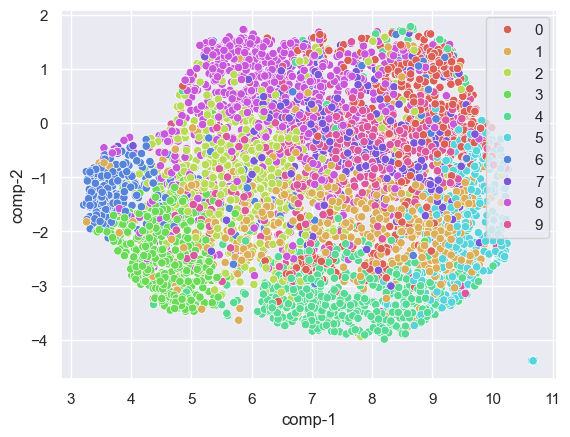

In [15]:
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y_euc.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df)

<Axes: xlabel='comp-1', ylabel='comp-2'>

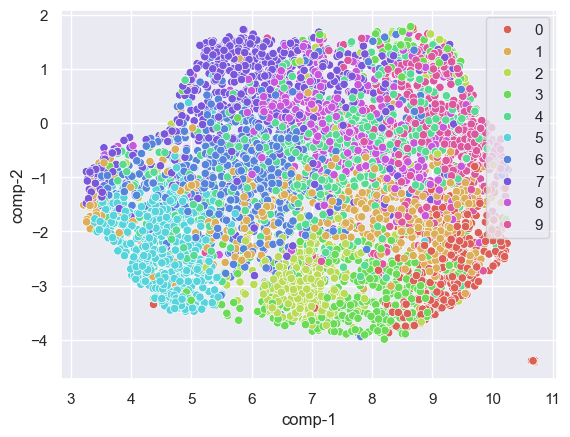

In [16]:
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y_cos.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df)

<Axes: xlabel='comp-1', ylabel='comp-2'>

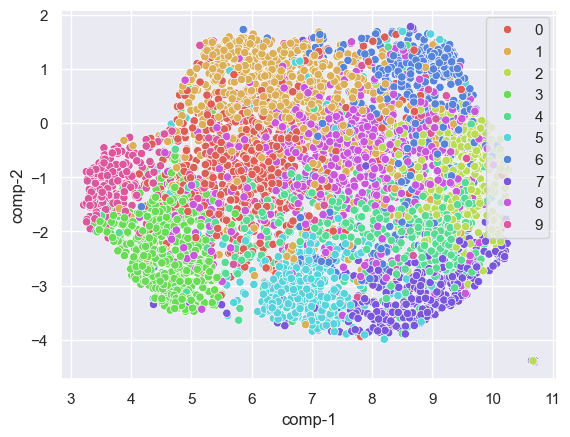

In [17]:
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y_cor.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df)

In [21]:
# sns.scatterplot(x="comp-1", y="comp-2", hue=df.y_mah.tolist(),
#                 palette=sns.color_palette("hls", 10),
#                 data=df)

Let's print examples of the text for each cluster

In [18]:
labels = labels_cos

for cluster in range(n_clusters):
    print(f"\nCluster {cluster}:")
    cluster_texts = [input_texts[i] for i in range(len(input_texts)) if labels[i] == cluster]
    for text in cluster_texts[:5]:
        print(f"- {text}")


Cluster 0:
- query: Thank you friend
- query: Super, thanks
- query: Happy to be able to help.
- query: Thanks! I love watching him every week
- query: LOL. Super cute!

Cluster 1:
- query: My favourite food is anything I didn't have to cook myself.
- query: Thanks DB, I'll see if I can find the book
- query: And then they say, “HAHAHAHHA IT WAS RIGHT THERE WOW!”
- query: Twilight... STILL a better love story than The Last Jedi!
- query: Sometimes life actually hands you lemons. We're just lucky that we have a proverbial phrase that gives us an idea of what we can do with them.

Cluster 2:
- query: To make her feel threatened
- query: Fucking coward.
- query: Stupidly stubborn / stubbornly stupid
- query: I miss them being alive
- query: When I feel down I listen to music.

Cluster 3:
- query: WHY THE FUCK IS BAYLESS ISOING
- query: Dirty Southern Wankers
- query: that is what retardation looks like
- query: You are going to do the dishes now
- query: Slowing things down now

Cluster 

## 6. Report

Make a conclusion and write a short report. What are the differnes between the methods used? What are their limitations? What is the applicability of each?

<b>1. Correlation Distance</b>
- Definition: Measures how well two vectors (or datasets) are correlated with each other.
- Usage: Useful for evaluating the similarity between vectors when the direction is important, not the absolute value.
- Properties: 
    - Not sensitive to the scale of the data; 
    - Suitable for normalized data.

<b>2. Euclidean Distance</b>
- Definition: The standard distance in space.
- Usage: Widely used in various tasks, including clustering and classification.
- Properties: 
    - Sensitive to scales and units of measurement
    - Not suitable for data with different scales.

<b>3. Cosine Distance</b>
- Definition: Measures the angle between two vectors, determining how much they point in one direction, not their length.
- Usage: It is often used in text processing and document analysis when similarity of directions is important.
- Properties: 
    - Not sensitive to vector length
    - Suitable for high-dimensional data.

<b>4. Mahalanobis Distance</b>
- Definition: Measures the distance between a point and a distribution, taking into account the correlation between variables.
- Usage: Useful in statistics and machine learning for outlier detection and clustering.
- Properties: 
    - Takes into account the data structure
    - Works well with multidimensional distributions.